In [1]:
import torch
from torch import nn

import numpy as np
from numpy import dtype
import matplotlib.pyplot as plt

from tqdm import trange

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available


In [2]:
## Generate data


def XOR_data(n_datapoints=100, seq_len=4):
    inputs = np.zeros([n_datapoints, seq_len, 1], dtype=np.float32)
    outputs = np.zeros([n_datapoints, 1], dtype=np.float32)
    for i in range(n_datapoints):
        # Generate input sequences
        for j in range(seq_len):
            bit = np.random.choice([0, 1])
            inputs[i, j, 0] = bit

        # Compute output
        xor = np.nansum(inputs[i]) % 2
        outputs[i] = xor

    return inputs, outputs

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Defining the layers
        self.rnn = nn.RNN(
            input_size, hidden_dim, n_layers, batch_first=True, nonlinearity="relu"
        )
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        out = out[:, -1]
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device)
        return hidden

In [4]:
## Instantiate model
model = Model(input_size=1, output_size=1, hidden_dim=30, n_layers=1)
model = model.to(device)

In [5]:
## Generate data
inputs_1, outputs_1 = XOR_data(n_datapoints=1000, seq_len=5)
inputs_2, outputs_2 = XOR_data(n_datapoints=1000, seq_len=4)
inputs_1 = torch.from_numpy(inputs_1).to(device)
outputs_1 = torch.from_numpy(outputs_1).to(device)
inputs_2 = torch.from_numpy(inputs_2).to(device)
outputs_2 = torch.from_numpy(outputs_2).to(device)

In [6]:
## Train

# Define hyperparameters
n_epochs = 1000
lr = 0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()  # Clears existing gradients from previous epoch
    output, hidden = model(inputs_1)
    loss = criterion(torch.squeeze(output), torch.squeeze(outputs_1))
    loss.backward()  # Does backpropagation and calculates gradients
    optimizer.step()  # Updates the weights accordingly

    optimizer.zero_grad()
    output, hidden = model(inputs_2)
    loss = criterion(torch.squeeze(output), torch.squeeze(outputs_2))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print("Epoch: {}/{}.............".format(epoch, n_epochs), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/1000............. Loss: 0.2654
Epoch: 20/1000............. Loss: 0.2508
Epoch: 30/1000............. Loss: 0.2487
Epoch: 40/1000............. Loss: 0.2486
Epoch: 50/1000............. Loss: 0.2486
Epoch: 60/1000............. Loss: 0.2486
Epoch: 70/1000............. Loss: 0.2485
Epoch: 80/1000............. Loss: 0.2485
Epoch: 90/1000............. Loss: 0.2484
Epoch: 100/1000............. Loss: 0.2484
Epoch: 110/1000............. Loss: 0.2483
Epoch: 120/1000............. Loss: 0.2482
Epoch: 130/1000............. Loss: 0.2476
Epoch: 140/1000............. Loss: 0.2439
Epoch: 150/1000............. Loss: 0.2365
Epoch: 160/1000............. Loss: 0.1401
Epoch: 170/1000............. Loss: 0.0079
Epoch: 180/1000............. Loss: 0.0007
Epoch: 190/1000............. Loss: 0.0002
Epoch: 200/1000............. Loss: 0.0001
Epoch: 210/1000............. Loss: 0.0001
Epoch: 220/1000............. Loss: 0.0001
Epoch: 230/1000............. Loss: 0.0000
Epoch: 240/1000............. Loss: 0.0000
E

In [7]:
def predict(model, sequence):
    input = torch.unsqueeze(
        torch.from_numpy(np.array([sequence], dtype=np.float32)), dim=2
    ).to(device)
    out, hidden = model(input)
    return out

In [8]:
## Predict on dataset
index = 1
input = inputs_1[index]
output = torch.squeeze(outputs_1[index])
prediction, _ = model(torch.unsqueeze(input, dim=0))
prediction = torch.squeeze(prediction)
print(f"Input:{input}")
print(f"Output:{output}")
print(f"Prediction:{prediction}")
print(criterion(prediction, output))

Input:tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.]], device='cuda:0')
Output:1.0
Prediction:1.00009024143219
tensor(8.1435e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:
print(predict(model, [1, 1, 0, 1, 0]))

tensor([[1.0001]], device='cuda:0', grad_fn=<AddmmBackward0>)


100%|██████████| 30/30 [00:03<00:00,  7.77it/s]


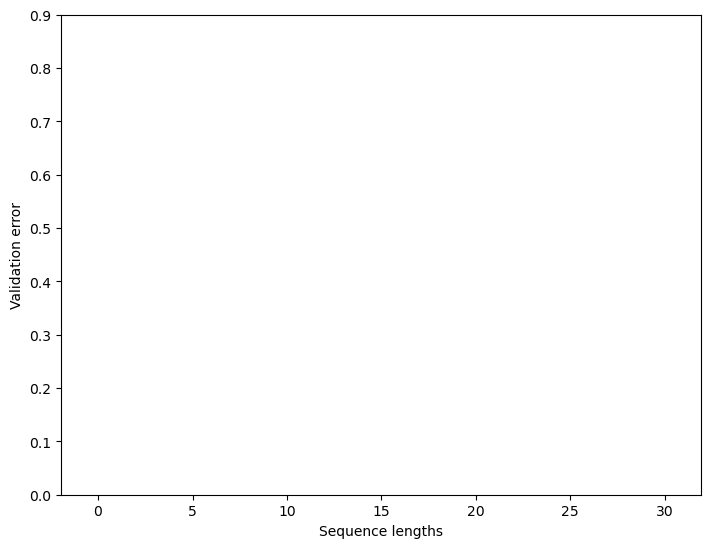

[0.00000000e+00 1.57340807e-09 2.47636134e-09 2.62129962e-09
 6.57108428e-13 6.57427942e-13 9.04603326e-07 2.89557897e-06
 9.57611792e-06 1.13852902e-05 6.80152743e-06 9.41197140e-06
 8.20344553e-07 7.41753274e-06 3.40551333e-06 9.23443804e-06
 1.53238398e-05 3.61751045e-05 1.45397007e-05 3.41994273e-05
 2.03459567e-05 3.86768188e-05 4.01833240e-05 1.33753510e-05
 6.28689168e-06 1.58927251e-05 2.75304556e-05 1.22139945e-05
 9.55874566e-06 5.51839294e-05 2.44710645e-05]


In [10]:
N = 30
val_err = np.zeros(N + 1)
for n in trange(1, N + 1):
    val_inputs, val_outputs = XOR_data(n_datapoints=1000, seq_len=n)
    val_inputs = torch.from_numpy(val_inputs).to(device)
    val_outputs = torch.from_numpy(val_outputs).to(device)
    prediction, _ = model(val_inputs)
    val_err[n] = criterion(torch.squeeze(prediction), torch.squeeze(val_outputs))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()
print(val_err)